To solve an inverse problem for diffusion-reaction systems for unknowns $D$ and $k_f$

$\frac{\partial C_A}{\partial t}=D\frac{\partial^2C_A}{\partial x^2}-k_fC_AC_B^2,\\\frac{\partial C_B}{\partial t}=D\frac{\partial^2C_B}{\partial x^2}-2k_fC_AC_B^2$

for $x \in [0,1]$ and $t \in [0,10]$ initial conditions

$C_A(x,0)=C_B(x,0)=e^{-20x}$

and boundary conditions

$\begin{gathered}
C_A(0,t)=C_B(0,t)=1 \\
C_A(1,t)=C_B(1,t)=0. 
\end{gathered}$

expected values of $D$ and $k_f$ are $2\cdot10^{-3} $ and $0.1$

Implementation

In [12]:
import deepxde as dde
import numpy as np
import torch

Now, we define the unknown variables $D$ and $k_f$ with initial guesses of 1 and 0.05, respectively:

In [13]:
D = dde.Variable(1.0)
kf = dde.Variable(0.05)

We define the computational geometries by using the built-in <u>**Interval()</u>** and <u>**TimeDomain()**</u> combining them with <u>**GeometryXTime()**</u>

In [14]:
geom = dde.geometry.Interval(0, 1)  #x的边界条件
timedomain = dde.geometry.TimeDomain(0, 10)  #t的边界条件
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  ##combine

Now, we create the reaction-inverse PDE:

ues Jacobian to represent 1-order Partial derivative

use Hessian to represent 2-order Partial derivative

Here, the first parameter is the $t$-coordinate, and it is represented by $x$

The second parameter has $C_A$ and $C_B$, which are represented by $y$.


In [15]:
def pde(x, y):
    ca, cb = y[:, 0:1], y[:, 1:2]  ##多维数组的切片语法
    dca_t = dde.grad.jacobian(y, x, i=0, j=1)
    dca_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)##等式1 eq_a

    dcb_t = dde.grad.jacobian(y, x, i=1, j=1)
    dcb_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)##等式2 eq_b

    eq_a = dca_t - 1e-3 * D * dca_xx + kf * ca * cb ** 2
    eq_b = dcb_t - 1e-3 * D * dcb_xx + 2 * kf * ca * cb ** 2 
    ##构造了偏微分方程组
    return [eq_a, eq_b]

Next, we consider the Dirichlet boundary conditions and initial conditions:

In [16]:
def fun_bc(x):  ##boundary conditions 边界条件
    return 1 - x[:, 0:1]

def fun_init(x): ##initial conditions 初始条件
    return np.exp(-20 * x[:, 0:1])

##边界条件的构造
bc_a = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=0
)

bc_b = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1
)

##初始条件的构造
ic1 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=0)
ic2 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=1)

Now, we generate the training data：

In [17]:
def gen_traindata():
    data = np.load("reaction.npz")
    t, x, ca, cb = data["t"], data["x"], data["Ca"], data["Cb"]
    X, T = np.meshgrid(x, t)
    X = np.reshape(X, (-1, 1))  ##reshape为一个 一列的二维数组
    T = np.reshape(T, (-1, 1))
    Ca = np.reshape(ca, (-1, 1))
    Cb = np.reshape(cb, (-1, 1))
    return np.hstack((X, T)), Ca, Cb  ##堆叠数组

After generating the data, we organize it:

In [18]:
observe_x, Ca, Cb = gen_traindata()
observe_y1 = dde.icbc.PointSetBC(observe_x, Ca, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, Cb, component=1)

Now, we can define the <u>**TimePDE**</u> problem as follows:

In [19]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_a, bc_b, ic1, ic2, observe_y1, observe_y2],
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
    anchors=observe_x,
    num_test=50000,
)

We have 2000 training residual points in the domain, 100 points on the boundary, 100 points for the initial conditions, and 50000 to test the PDE residual. anchors specifies the training points as well.

Now, we create the network:

In [20]:
net = dde.nn.FNN([2] + [20] * 3 + [2], "tanh", "Glorot uniform")

This network has two inputs, one for the $t$-coordinate and one for the $x$-coordinate, and three hidden layers with 20 neurons each. 

The output layer has two outputs, one for $C_A$ and one for $C_B$.

Activation: tanh; Initializer: Glorot uniform.

Now, we create the <u>Model</u> and specify the optimizer, learning rate, and <u>external_trainable_variables</u>.
Also output the values of $D$ and $k_f$ every 1000 iterations.

In [21]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[kf, D])
variable = dde.callbacks.VariableValue([kf, D], period=1000, filename="variables.dat")

Compiling model...
'compile' took 0.000587 s



Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.65e-03, 1.55e-03, 5.97e-01, 6.55e-01, 2.88e-02, 6.76e-02, 9.15e-02, 1.04e-01]    [1.63e-03, 1.55e-03, 5.97e-01, 6.55e-01, 2.88e-02, 6.76e-02, 9.15e-02, 1.04e-01]    []  
1000      [1.68e-04, 1.78e-04, 3.59e-04, 3.53e-04, 6.46e-04, 7.15e-04, 2.59e-04, 1.40e-04]    [1.31e-04, 1.35e-04, 3.59e-04, 3.53e-04, 6.46e-04, 7.15e-04, 2.59e-04, 1.40e-04]    []  
2000      [4.95e-05, 7.69e-05, 6.19e-05, 7.06e-05, 1.09e-04, 1.42e-04, 5.26e-05, 6.37e-05]    [3.92e-05, 6.30e-05, 6.19e-05, 7.06e-05, 1.09e-04, 1.42e-04, 5.26e-05, 6.37e-05]    []  
3000      [5.66e-05, 6.21e-05, 3.47e-04, 3.56e-04, 7.95e-05, 5.03e-05, 1.96e-04, 1.84e-04]    [5.02e-05, 5.20e-05, 3.47e-04, 3.56e-04, 7.95e-05, 5.03e-05, 1.96e-04, 1.84e-04]    []  
4000      [4.52e-05, 5.23e-05, 1.75e-05, 2.01e-05, 2.28e-05

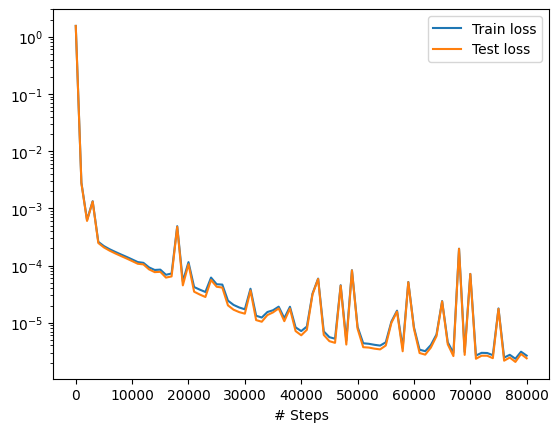

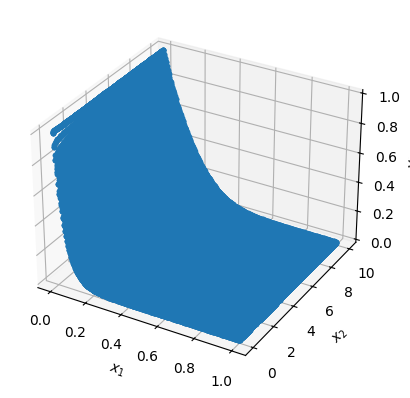

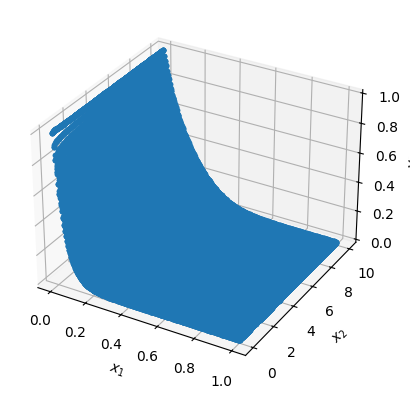

In [22]:
losshistory, train_state = model.train(iterations=80000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)